In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)
classpath = 'd:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar'

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;
from rademacher_utils import calc_rademacher_biclassifiers, calc_margin_loss

In [3]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred, labels=[1, -1]):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        columns=['a(x) = '+str(labels[0]), 'a(x) = '+str(labels[1])],
        index=['y = '+str(labels[0]), 'y = '+str(labels[1])],
    ).T

In [4]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [5]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf
    
#Ada-boost sklearn
def get_predict_sklearn(X_train, X_test, y_train, y_test):
    clf = AdaBoostClassifier(n_estimators=150, random_state=0)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    return y_pred, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

#Java
def get_predicts_java_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostJavaClassifier_v1(path=classpath)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

In [6]:
def calc_2classifiers_params(X_data, y_data, repeat_count = 5, test_share = 0.33):
    cnt = 0
    #marginsL, marginsJ, 
    classifiersL, classifiersJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, accuraciesL, accuraciesJ = [], [], [], []
    while cnt < repeat_count:
        X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_share)
        #linear
        clf2000L = AdaBoostLinear_v1()
        _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
        separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
        if separated < 1:
            print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            continue
        #ada boost
        clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
        result = clf2000J.fit(X_train2000, y_train2000)
        separated = accuracy_score(y_train2000, np.array(clf2000J.predict(X_train2000)))
        if separated < 1:
            print("Failed to separate, accuracy = {}".format(separated))
            continue
        X_trains.append(X_train2000)
        y_trains.append(y_train2000)
        classifiersL.append(clf2000L)
        classifiersJ.append(clf2000J)
        rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 10000))
        marginsL.append(clf2000L.get_margin())
        marginsJ.append(clf2000J.get_margin_l1(X_train2000))
        accuraciesL.append(accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
        accuraciesJ.append(accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
        cnt += 1
        
    return classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, accuraciesL, accuraciesJ


In [40]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def draw_2classifiers_margin_bound(X_trains, y_trains, classifiersL, classifiersJ, rademachers, rho_vars):

    options = [
        ('r', 'Rightside value - linear algorithm'),
        ('g', 'Rightside value - ada boost algorithm')
    ]
    delta = 0.05

    #rho_vars = np.arange(0.2, 1, 0.05)
    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))

    plt.ylabel('Parameter value')
    plt.xlabel('Rho value')
    cnt = 0

    for X_train, y_train, clfL, clfJ, rdm in zip(X_trains, y_trains, classifiersL, classifiersJ, rademachers):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        cnt += 1
        for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            #print("Rdm={}, sample_size={}, rho={}".format(rdm, sample_size, rho_var))
            valueTail = 2*rdm/rho_var + 3*math.sqrt(math.log(2/delta)/(2*sample_size))
            valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var) + valueTail)
            valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var) + valueTail)

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(rademachers)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(rademachers)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.33, 1))

In [41]:
REPEAT_COUNT = 5
TEST_SIZE = 0.33

### Simple separable dataset, 6 rows 4 features

In [93]:
X_train = np.array([[0.6476239, -0.81753611, -1.61389785, -0.21274028],
       [-2.3748206 ,  0.82768797, -0.38732682, -0.30230275],
       [ 1.51783379,  1.22140561, -0.51080514, -1.18063218],
       [-0.98740462,  0.99958558, -1.70627019,  1.9507754],
       [-1.43411205,  1.50037656, -1.04855297, -1.42001794],
       [ 0.29484027, -0.79249401, -1.25279536,  0.77749036]])

y_train = np.array([1, -1, -1, 1, 1, -1])

clf = AdaBoostStandardClassifier_v1(n_estimators=100)
result, history = clf.fit(X_train, y_train, trace=True)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
rho = clf.get_margin_l1(X_train)
print("Ada boost margin:", rho)
rad = calc_rademacher_biclassifiers(X_train, 64)
print("Rad:", rad)
right_side = 2*rad/rho + 3*math.sqrt(math.log(2/rho)/(2*6789))
print("Right side value:", right_side)

clf = AdaBoostLinear_v1()
result, message, log = clf.fit(X_train, y_train, trace=False)
y_pred = clf.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Linear classifier margin: ", clf.get_margin())

clfj = AdaBoostJavaClassifier_v1(path=classpath)
result = clfj.fit(X_train, y_train)
y_pred = clfj.predict(X_train)
assert (y_train==y_pred).all(), 'Wrong answer'
print("Java ada boost margin:", clfj.get_margin_l1(X_train))

rad = calc_rademacher_biclassifiers(X_train, 64)

print("Radj:", clfj.calc_rademacher_biclassifiers(X_train, 64))

Ada boost margin: 0.4431265830030106
Rad: 0.8333333333333329
Right side value: 3.792758322476644
Linear classifier margin:  0.4545454546788366
Java ada boost margin: 0.4470040500164032
Radj: 0.8333333333333329


In [94]:
print("Margin loss java:", clfj.calc_margin_loss(X_train, y_train, 0.4470040500164032))
print("Margin loss linear:", calc_margin_loss(X_train, y_train, clf.predict_raw, 0.4545454546788366))

Margin loss java: 0.0
Margin loss linear: 5.3758997253794405e-11


### Separable normaly distributed data, 2 features, train set - 1333, test set - 667

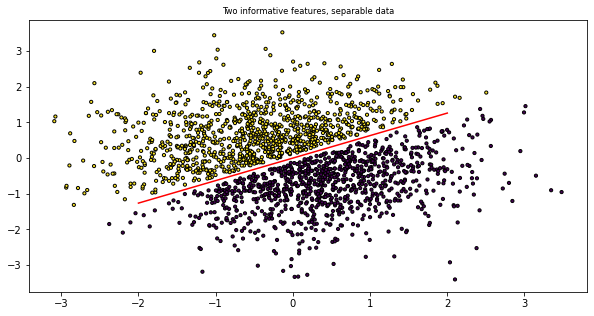

In [42]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_2000, y_2000, v_normal = make_classification_normal(2, 2000, rho=0.1)
draw_data_by_coord01(x_2000, y_2000, v_normal)

##### Comparison of linear and ada boost algorithms

In [43]:
start = time.time()
cnt = 0
classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, accuraciesL, accuraciesJ = \
    calc_2classifiers_params(x_2000, y_2000, repeat_count = REPEAT_COUNT, test_share = TEST_SIZE)
end = time.time()
print("Elapsed time: {}".format(end - start))


Elapsed time: 381.9965124130249


In [44]:
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains, y_trains, classifiersL, classifiersJ, rademachers)
print('time elapsed:', (time.time() - start_time))


TypeError: draw_2classifiers_margin_bound() missing 1 required positional argument: 'rho_vars'

<Figure size 1080x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.figure(figsize=(15,10))

options = [
    ('r', 'Rightside value - linear algorithm'),
    ('g', 'Rightside value - ada boost algorithm')
]

rho_vars = np.arange(0.0, 1, 0.05)
avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))
start_time = time.time()

plt.ylabel('Margin loss value')
plt.xlabel('Rho value')
cnt = 0

for X_train, y_train, clfL, clfJ, rdm in zip(X_trains, y_trains, classifiersL, classifiersJ, rademachers):
    sample_size = X_train.shape[0]
    valuesL, valuesJ = [], []
    cnt += 1
    for rho_var in tqdm(rho_vars, total=len(rho_vars)):
        #valueTail = 2*rdm/rho_var + 3*math.sqrt(math.log(2/rho_var)/(2*sample_size))
        valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var))
        valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var))
        
    bar.finish()
        
    avgL += np.array(valuesL)
    avgJ += np.array(valuesJ)
    plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
    plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)
    
plt.plot(rho_vars, avgL / (1. * len(rademachers)), options[0][0], linewidth=1.0, label=options[0][1])
plt.plot(rho_vars, avgJ / (1. * len(rademachers)), options[1][0], linewidth=1.0, label=options[1][1])
dummy = plt.legend(bbox_to_anchor=(0.33, 1))
print('end , time:', (time.time() - start_time))


In [ ]:
vector_ones = np.ones(len(accuraciesL))
errorsL, errorsJ = vector_ones - accuraciesL, vector_ones - accuraciesJ
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Linear emperical error: average-{:1.10f}, standard deviation-{:1.10f}".format(np.average(errorsL), np.std(errorsL)))
print("Ada boost emperical error: average-{:1.10f}, standard deviation-{:1.10f}".format(np.average(errorsJ), np.std(errorsJ)))
print("Linear average margin: average-{:1.10f}, standard deviation-{:1.10f}".format(np.average(marginsL), np.std(marginsL)))
print("Ada boost average margin: average-{:1.10f}, standard deviation-{:1.10f}".format(np.average(marginsJ), np.std(marginsJ)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, standard deviation-{:1.10f}"\
      .format(np.average(rademachers), np.std(rademachers)))


##### Metrics on different algorithms

In [10]:
#Linear clasifier
X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(x_2000, y_2000, test_size=TEST_SIZE)
clf2000L = AdaBoostLinear_v1()
_, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
print("LINEAR ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000L.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000L.predict(X_test2000), labels=[-1, 1])


LINEAR ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = -1,y = 1
a(x) = -1,327,0
a(x) = 1,0,333


In [11]:
#Ada boost clasifier
clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
_ = clf2000J.fit(X_train2000, y_train2000)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000J.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000J.predict(X_test2000), labels=[1, -1])

ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = 1,y = -1
a(x) = 1,333,0
a(x) = -1,0,327


##### Sklearn algorithm

In [12]:
clf2000std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2000std.fit(X_train2000, y_train2000)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train2000, clf2000std.predict(X_train2000))))
compute_confusion_matrix(y_test2000, clf2000std.predict(X_test2000), labels=[-1, 1])

SKLEARN ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 1.00000
F-score: 1.00000
Precision: 1.00000
Recall: 1.00000
Accuracy (balanced): 1.00000
MCC: 1.00000


,y = -1,y = 1
a(x) = -1,327,0
a(x) = 1,0,333


### Separable data, 10 clusters, 50 features, 20 informative, train set - 667, test set - 333

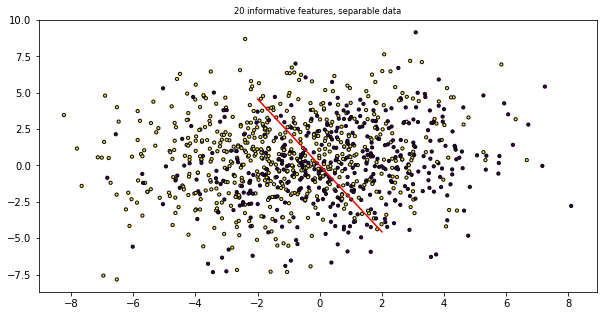

In [106]:
from sklearn.datasets import make_classification

x_1000, _ = make_classification(n_samples=1000, n_features=50,n_informative=20
                                , n_redundant=20, random_state=0, n_clusters_per_class=5, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("20 informative features, separable data", fontsize="small")
x_1000, y_1000, v_normal = make_separable_labels(x_1000, rho=0.1)
draw_data_by_coord01(x_1000, y_1000, v_normal)


##### Comparison of linear and ada boost algorithms

In [107]:
start = time.time()
classifiers2L, classifiers2J, rademachers2, X_trains2, y_trains2, margins2L, margins2J, accuracies2L, accuracies2J = \
    calc_2classifiers_params(x_1000, y_1000, repeat_count = REPEAT_COUNT, test_share = TEST_SIZE)
print("Elapsed time: {}".format(time.time() - start))


Elapsed time: 3536.68190574646


'\ncnt = 0\nmargins_linear, accuracies_linear, margins_ada, accuracies_ada, rademachers = [], [], [], [], []\nwhile cnt < REPEAT_COUNT:\n    X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)\n    #Linear\n    clfL = AdaBoostLinear_v1()\n    _, _, _ = clfL.fit(X_train1000, y_train1000, allow_nonseparable=True)\n    separated = accuracy_score(y_train1000, clfL.predict(X_train1000))\n    if separated < 1:\n        print("Failed to separate, accuracy = {}".format(separated))\n        continue\n    margins_linear.append(clfL.get_margin())\n    accuracies_linear.append(accuracy_score(y_test1000, clfL.predict(X_test1000)))\n    #Ada boost\n    clfJ = AdaBoostJavaClassifier_v1(path=classpath)\n    result = clfJ.fit(X_train1000, y_train1000)\n    separated = accuracy_score(y_train1000, clfJ.predict(X_train1000))\n    if separated < 1:\n        print("Failed to separate, accuracy = {}".format(separated))\n        continue\n    margins_ada.ap

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [05:55<00:00, 22.20s/it]

Elapsed time: 3238.332745552063


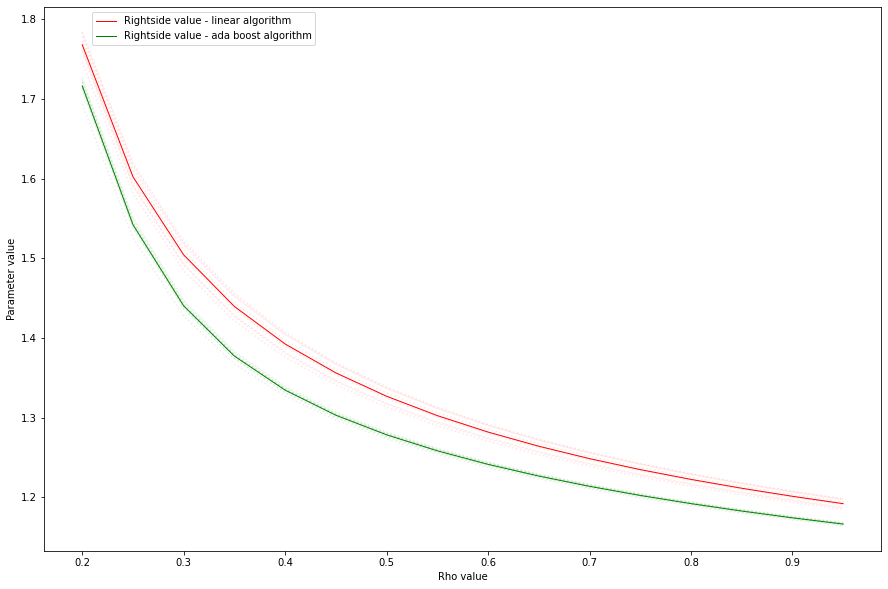

In [108]:
start = time.time()
plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains2, y_trains2, classifiers2L, classifiers2J, rademachers2)
print("Elapsed time: {}".format(time.time() - start))

In [109]:
vector2_ones = np.ones(len(accuracies2L))
errors2L, errors2J = vector2_ones - accuracies2L, vector2_ones - accuracies2J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errors2L), np.std(errors2L)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errors2J), np.std(errors2J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(margins2L), np.std(margins2L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(margins2J), np.std(margins2J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rademachers2), np.std(rademachers2)))

IN A SERIES OF TESTS OF 9 EXPERIMENTS:
Linear emperical error: average-0.0966329966, std. deviation-0.0094155767
Ada boost emperical error: average-0.1006734007, std. deviation-0.0142691044
Linear average margin: average-0.0732399895, std. deviation-0.0012750082
Ada boost average margin: average-0.0238190335, std. deviation-0.0041399692
Rademacher emperical complexity calculated: average-0.1265443781, std. deviation-0.0001466503


##### Metrics on different algorithms

In [15]:
X_train1000, X_test1000, y_train1000, y_test1000 = train_test_split(x_1000, y_1000, test_size=TEST_SIZE)
clf1000L = AdaBoostLinear_v1()
_, _, _ = clf1000L.fit(X_train1000, y_train1000, allow_nonseparable=True)
print("LINEAR ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf1000L.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf1000L.predict(X_test1000), labels=[-1, 1])

LINEAR ALGORITHM:
Separated: 1.0
Accuracy: 0.90606
F-score: 0.92072
Precision: 0.92308
Recall: 0.91837
Accuracy (balanced): 0.90321
MCC: 0.80549


,y = -1,y = 1
a(x) = -1,119,16
a(x) = 1,15,180


In [16]:
clf1000J = AdaBoostJavaClassifier_v1(path=classpath)
clf1000J.fit(X_train1000, y_train1000)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf1000J.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf1000J.predict(X_test1000), labels=[-1, 1])

ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 0.88788
F-score: 0.90585
Precision: 0.90355
Recall: 0.90816
Accuracy (balanced): 0.88319
MCC: 0.76729


,y = -1,y = 1
a(x) = -1,115,18
a(x) = 1,19,178


In [17]:
clf2std = AdaBoostClassifier(n_estimators=150, random_state=0)
clf2std.fit(X_train1000, y_train1000)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(accuracy_score(y_train1000, clf2std.predict(X_train1000))))
compute_confusion_matrix(y_test1000, clf2std.predict(X_test1000), labels=[-1, 1])

SKLEARN ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 0.87879
F-score: 0.89637
Precision: 0.91053
Recall: 0.88265
Accuracy (balanced): 0.87789
MCC: 0.75100


,y = -1,y = 1
a(x) = -1,117,23
a(x) = 1,17,173


### Separable data, 10 clusters, 50 features, 20 informative, train set - 1667, test set - 833

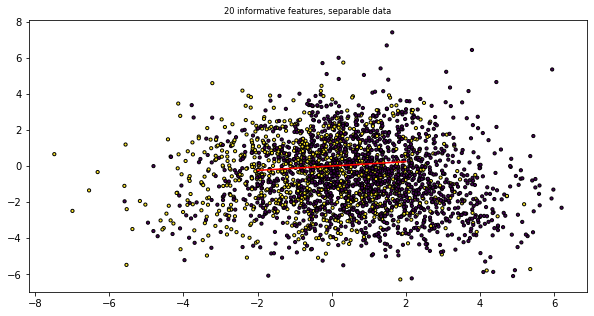

In [14]:
from sklearn.datasets import make_classification

x_10000, _ = make_classification(n_samples=2500, n_features=20,n_informative=10
                                , n_redundant=5, random_state=0, n_clusters_per_class=5, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("20 informative features, separable data", fontsize="small")
x_10000, y_10000, v_normal = make_separable_labels(x_10000, rho=0.5)
draw_data_by_coord01(x_10000, y_10000, v_normal)


In [15]:
start = time.time()
classifiers3L, classifiers3J, rademachers3, X_trains3, y_trains3, margins3L, margins3J, accuracies3L, accuracies3J = \
    calc_2classifiers_params(x_10000, y_10000, repeat_count = 1, test_share = TEST_SIZE)
print("Elapsed time: {}".format(time.time() - start))

Elapsed time: 1131.9588329792023


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [11:53<00:00, 44.58s/it]

Elapsed time: 713.2644338607788


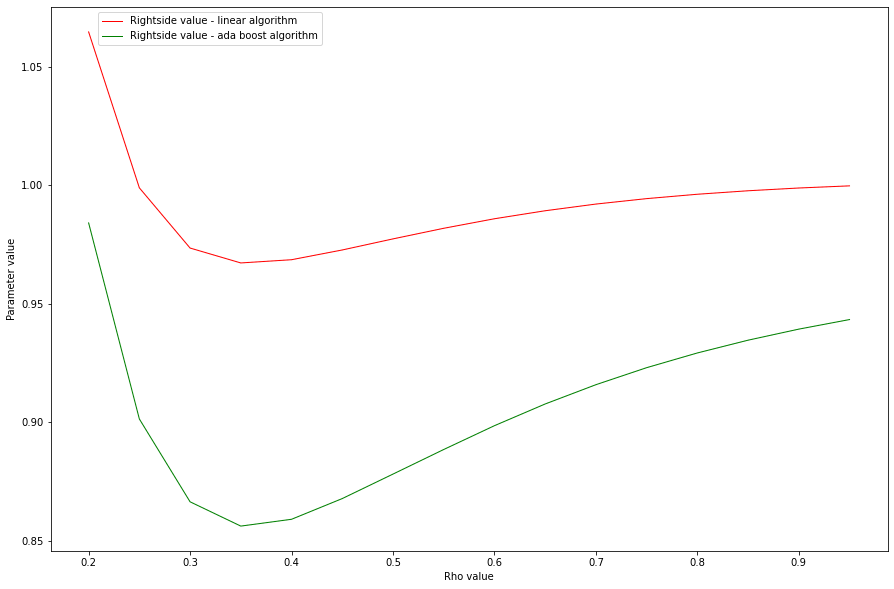

In [16]:
start = time.time()
plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains3, y_trains3, classifiers3L, classifiers3J, rademachers3)
print("Elapsed time: {}".format(time.time() - start))

In [17]:
vector3_ones = np.ones(len(accuracies3L))
errors3L, errors3J = vector3_ones - accuracies3L, vector3_ones - accuracies3J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(3))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errors3L), np.std(errors3L)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errors3J), np.std(errors3J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(margins3L), np.std(margins3L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(margins3J), np.std(margins3J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rademachers3), np.std(rademachers3)))

IN A SERIES OF TESTS OF 3 EXPERIMENTS:
Linear emperical error: average-0.0084848485, std. deviation-0.0000000000
Ada boost emperical error: average-0.0157575758, std. deviation-0.0000000000
Linear average margin: average-0.0660469784, std. deviation-0.0000000000
Ada boost average margin: average-0.0122353574, std. deviation-0.0000000000
Rademacher emperical complexity calculated: average-0.0733139104, std. deviation-0.0000000000


### Breast cancer data set

In [24]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/breast-cancer/'

df = pd.read_csv(path+'breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [25]:
raw = df.to_numpy(copy=True)
x_data = raw[:, 1:10]
y_data = raw[:, 10].astype(int) - 3

print("Breast cancer: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Breast cancer: 699 rows, 9 features


#### Check if dataset is separable

In [26]:
from sklearn import svm

clf = svm.SVC(C = 10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)


1.0

##### Comparison of linear and ada boost algorithms

In [27]:
start = time.time()
cnt = 0
marginsL, accuraciesL, marginsJ, accuraciesJ, rademachers = [], [], [], [], []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    rademachers.append(calc_rademacher_biclassifiers(X_train, 1000))
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        continue
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        continue

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Breast cancer data set, 9 features, 468 rows in train set, 231 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT, np.average(marginsJ), np.average(accuraciesJ)))
print("Rademacher calculated: {}".format(rademachers))

Failed to separate in ada boost algorithm, accuracy = 0.9807692307692307
Failed to separate in ada boost algorithm, accuracy = 0.9935897435897436
Failed to separate in ada boost algorithm, accuracy = 0.9893162393162394
Failed to separate in ada boost algorithm, accuracy = 0.9914529914529915
Failed to separate in ada boost algorithm, accuracy = 0.9957264957264957
Failed to separate in ada boost algorithm, accuracy = 0.9978632478632479
Failed to separate in ada boost algorithm, accuracy = 0.9871794871794872
Breast cancer data set, 9 features, 468 rows in train set, 231 rows in test set
Elapsed time: 423.1811318397522
Linear classifier, 3 experiments. Avg. margin on train set: 0.0558692552, avg. accuracy on test set: 0.9466089466
Ada boost classifier, 3 experiments. Avg. margin on train set: 0.0099325322, avg. accuracy on test set: 0.9480519481
Rademacher calculated: [0.1177264957264961, 0.11987179487179553, 0.11837606837606865, 0.11975213675213732, 0.1198162393162396, 0.11951709401709434

##### Metrics on different algorithms

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

LINEAR ALGORITHM:
Separated: 1.0, margin: 0.060384438112264696
Accuracy: 0.91342
F-score: 0.88372
Precision: 0.92683
Recall: 0.84444
Accuracy (balanced): 0.90095
MCC: 0.81723


,y = -1,y = 1
a(x) = -1,135,14
a(x) = 1,6,76


In [23]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA-BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

ADA-BOOST ALGORITHM:
Separated: 0.9957264957264957, margin: 0.0013122915569797513
Accuracy: 0.95238
F-score: 0.92810
Precision: 0.92208
Recall: 0.93421
Accuracy (balanced): 0.94775
MCC: 0.89255


,y = -1,y = 1
a(x) = -1,149,5
a(x) = 1,6,71


In [24]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA-BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

SKLEARN ADA-BOOST ALGORITHM:
Separated: 1.0
Accuracy: 0.94805
F-score: 0.92000
Precision: 0.93243
Recall: 0.90789
Accuracy (balanced): 0.93782
MCC: 0.88172


,y = -1,y = 1
a(x) = -1,150,7
a(x) = 1,5,69


### Ionosphere

In [29]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/ionosphere/'

df = pd.read_csv(path+'ionosphere.data', header=None)
df['decoded'] = df[34].apply(lambda x: -1 if x == 'b' else 1)
#df.fillna(0, inplace=True)
df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,decoded
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b,-1
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b,-1
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g,1


In [30]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([34, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)
print("Ionosphere: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Ionosphere: 351 rows, 34 features


#### Check if dataset is separable

In [31]:
from sklearn import svm

clf = svm.SVC(C=10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

1.0

In [35]:
start = time.time()
cnt = 0
clfs_L, clfs_J, rads_, X_trains_, y_trains_, mgns_L, mgns_J, acrcs_L, acrcs_J = \
    calc_2classifiers_params(x_data, y_data, repeat_count = 5, test_share = 0.33)
end = time.time()
print("Elapsed time: {}".format(end - start))

Elapsed time: 251.34957766532898


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [06:38<00:00,  4.15s/it]

time elapsed: 1903.1171689033508


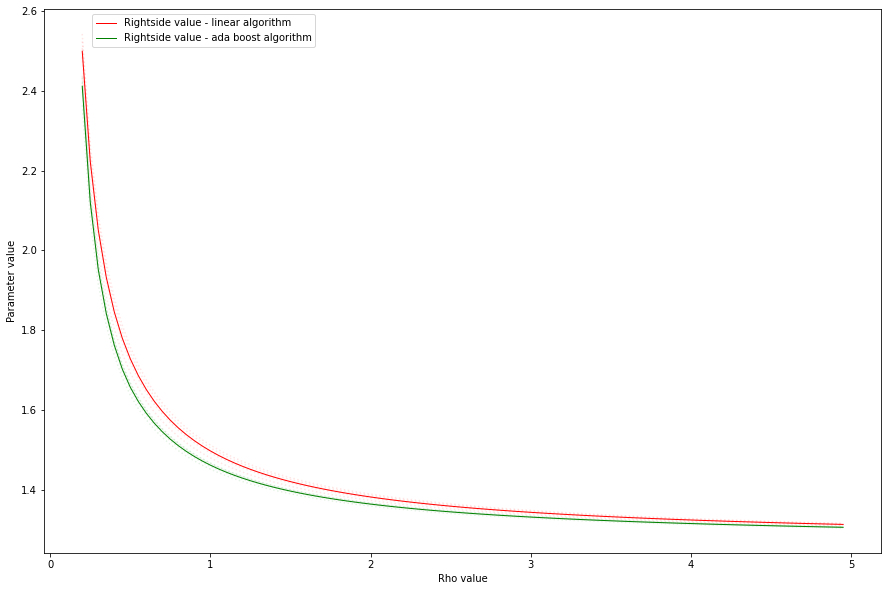

In [36]:
rho_vars = np.arange(0.2, 5, 0.05)
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains_, y_trains_, clfs_L, clfs_J, rads_, rho_vars) #
print('time elapsed:', (time.time() - start_time))

In [37]:
vector__ones = np.ones(len(acrcs_L))
errs_L, errs_J = vector__ones - acrcs_L, vector__ones - acrcs_J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(5))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs_L), np.std(errs_J)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs_J), np.std(errs_J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns_L), np.std(mgns_L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns_J), np.std(mgns_J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads_), np.std(rads_)))

IN A SERIES OF TESTS OF 5 EXPERIMENTS:
Linear emperical error: average-0.1206896552, std. deviation-0.0150306860
Ada boost emperical error: average-0.1155172414, std. deviation-0.0150306860
Linear average margin: average-0.1142714231, std. deviation-0.0062328242
Ada boost average margin: average-0.0735545620, std. deviation-0.0059212681
Rademacher emperical complexity calculated: average-0.1963545532, std. deviation-0.0003043362


##### Comparison of linear and ada boost algorithms

In [31]:
REPEAT_COUNT2 = 10
start = time.time()
cnt = 0
marginsL, accuraciesL, marginsJ, accuraciesJ, rademachers = [], [], [], [], []
while cnt < REPEAT_COUNT2:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    rademachers.append(calc_rademacher_biclassifiers(X_train, 1000))
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        continue
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        continue

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Ionosphere data set, 34 features, 234 rows in train set, 117 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT2, np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(REPEAT_COUNT2, np.average(marginsJ), np.average(accuraciesJ)))
print("Rademacher calculated: {}".format(rademachers))

Ionosphere data set, 34 features, 234 rows in train set, 117 rows in test set
Elapsed time: 506.82837438583374
Linear classifier, 10 experiments. Avg. margin on train set: 0.1161441866, avg. accuracy on test set: 0.9000000000
Ada boost classifier, 10 experiments. Avg. margin on train set: 0.0807315300, avg. accuracy on test set: 0.9103448276
Rademacher calculated: [0.19792340425531896, 0.19577021276595769, 0.19600851063829786, 0.19913191489361717, 0.19700425531914903, 0.19606808510638302, 0.19565957446808518, 0.19602553191489377, 0.19702127659574462, 0.19539574468085127]


##### Metrics on different algorithms

In [29]:
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

LINEAR ALGORITHM:
Separated: 1.0, margin: 0.10258620352881125
Accuracy: 0.93966
F-score: 0.95597
Precision: 0.95000
Recall: 0.96203
Accuracy (balanced): 0.92696
MCC: 0.86027


,y = -1,y = 1
a(x) = -1,33,3
a(x) = 1,4,76


In [30]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

ADA BOOST ALGORITHM:
Separated: 1.0, margin: 0.06440361823266004
Accuracy: 0.95690
F-score: 0.96894
Precision: 0.95122
Recall: 0.98734
Accuracy (balanced): 0.93962
MCC: 0.90027


,y = -1,y = 1
a(x) = -1,33,1
a(x) = 1,4,78


In [31]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

SKLEARN ADA BOOST ALGORITHM:
Separated: 1.0
Accuracy: 0.95690
F-score: 0.96855
Precision: 0.96250
Recall: 0.97468
Accuracy (balanced): 0.94680
MCC: 0.90025


,y = -1,y = 1
a(x) = -1,34,2
a(x) = 1,3,77


### Diabet

In [32]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/diabet/'

df = pd.read_csv(path+'diabetes.data', header=None)
df['decoded'] = df[8].apply(lambda x: -1 if x == 'tested_negative' else 1)
df.head(5)

,0,1,2,3,4,5,6,7,8,decoded
0,6,148,72,35,0,33.6,0.627,50,tested_positive,1
1,1,85,66,29,0,26.6,0.351,31,tested_negative,-1
2,8,183,64,0,0,23.3,0.672,32,tested_positive,1
3,1,89,66,23,94,28.1,0.167,21,tested_negative,-1
4,0,137,40,35,168,43.1,2.288,33,tested_positive,1


In [33]:
raw = df.copy(True)
y_data_df = raw['decoded']
x_data_df = raw.drop([8, 'decoded'], axis = 1)
y_data = y_data_df.to_numpy(copy=True)
x_data = x_data_df.to_numpy(copy=True)

print("Diabet: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Diabet: 768 rows, 8 features


#### Check if dataset is separable

In [34]:
from sklearn import svm

clf = svm.SVC(C=10**8)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

0.8528645833333334

In [35]:
clf = AdaBoostLinear_v1()
result, message, _ = clf.fit(x_data, y_data, allow_nonseparable=True)
separated = accuracy_score(y_data, clf.predict(x_data))
print("Separated: {}, margin: {}".format(separated, clf.get_margin()))

Separated: 1.0, margin: 0.0070401921891259074


#### Comparison of linear and ada boost algorithms

In [36]:
start = time.time()
cnt, skips = 0, 0
SKIPS_LIMIT = 5
marginsL, accuraciesL, marginsJ, accuraciesJ, rademachers = [], [], [], [], []
while cnt < REPEAT_COUNT:
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
    rademachers.append(calc_rademacher_biclassifiers(X_train, 1000))
    y_predL, marginL, separatedL, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separatedL < 1:
        print("Failed to separate in linear algorithm, accuracy = {}".format(separatedL))
        skips += 1
        if skips < SKIPS_LIMIT:
            continue
        else:
            break
    
    y_predJ, marginJ, separatedJ, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test) 
    if separatedJ < 1:
        print("Failed to separate in ada boost algorithm, accuracy = {}".format(separatedJ))
        skips += 1
        if skips < SKIPS_LIMIT:
            continue
        else:
            break

    marginsL.append(marginL)
    accuraciesL.append(accuracy_score(y_test, y_predL))
    marginsJ.append(marginJ)
    accuraciesJ.append(accuracy_score(y_test, y_predJ))
    
    cnt += 1

end = time.time()

print("Diabet data set, 8 features, 514 rows in train set, 254 rows in test set")
print("Elapsed time: {}".format(end - start))
print("Linear classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(len(marginsL), np.average(marginsL), np.average(accuraciesL)))
print("Ada boost classifier, {} experiments. Avg. margin on train set: {:1.10f}, avg. accuracy on test set: {:1.10f}"\
      .format(len(marginsJ), np.average(marginsJ), np.average(accuraciesJ)))
print("Rademacher calculated: {}".format(rademachers))

Failed to separate in ada boost algorithm, accuracy = 0.8443579766536965
Failed to separate in ada boost algorithm, accuracy = 0.8560311284046692
Failed to separate in ada boost algorithm, accuracy = 0.8482490272373541
Failed to separate in ada boost algorithm, accuracy = 0.8443579766536965
Failed to separate in ada boost algorithm, accuracy = 0.8404669260700389
Diabet data set, 8 features, 514 rows in train set, 254 rows in test set
Elapsed time: 227.2576298713684
Linear classifier, 0 experiments. Avg. margin on train set: nan, avg. accuracy on test set: nan
Ada boost classifier, 0 experiments. Avg. margin on train set: nan, avg. accuracy on test set: nan
Rademacher calculated: [0.11785214007782183, 0.11753696498054571, 0.1188210116731525, 0.11812451361867791, 0.11706225680933953]


d:\Programs-python\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
d:\Programs-python\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Metrics on different algorithms

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE)
y_pred, margin, separated, _ = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
print("LINEAR ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

LINEAR ALGORITHM:
Separated: 1.0, margin: 0.010947426603926
Accuracy: 0.66142
F-score: 0.52747
Precision: 0.52747
Recall: 0.52747
Accuracy (balanced): 0.63183
MCC: 0.26367


,y = -1,y = 1
a(x) = -1,120,43
a(x) = 1,43,48


In [41]:
y_pred, margin, separated, _ = get_predicts_java_v1(X_train, X_test, y_train, y_test)
print("ADA BOOST ALGORITHM:")
print("Separated: {}, margin: {}".format(separated, margin))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

ADA BOOST ALGORITHM:
Separated: 0.8599221789883269, margin: 3.9434436290737644e-05
Accuracy: 0.74803
F-score: 0.61446
Precision: 0.68000
Recall: 0.56044
Accuracy (balanced): 0.70660
MCC: 0.43433


,y = -1,y = 1
a(x) = -1,139,40
a(x) = 1,24,51


In [42]:
y_pred, separated, _ = get_predict_sklearn(X_train, X_test, y_train, y_test)
print("SKLEARN ADA BOOST ALGORITHM:")
print("Separated: {}".format(separated))
compute_confusion_matrix(y_test, y_pred, labels=[-1, 1])

SKLEARN ADA BOOST ALGORITHM:
Separated: 0.8891050583657587
Accuracy: 0.72441
F-score: 0.56790
Precision: 0.64789
Recall: 0.50549
Accuracy (balanced): 0.67606
MCC: 0.37623


,y = -1,y = 1
a(x) = -1,138,45
a(x) = 1,25,46
